In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import nltk
import datetime
nltk.download('vader_lexicon')

# Load a subset of the data
train_data = pd.read_csv('data/train.csv', nrows=500000)
test_data = pd.read_csv('data/test.csv')

# Check for missing values
print(train_data.isnull().sum())

train_data = train_data.drop(['Id'], axis=1)

# Drop rows where 'Score' is missing for training
train_data = train_data.dropna(subset=['Score'])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ericgulottyjr/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Id                         0
ProductId                  0
UserId                     0
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Time                       0
Summary                   13
Text                      21
Score                      0
dtype: int64


In [28]:
# Fill missing values for the 'HelpfulnessRatio' and 'Year' columns
train_data['HelpfulnessNumerator'] = train_data['HelpfulnessNumerator'].fillna(0)
train_data['HelpfulnessDenominator'] = train_data['HelpfulnessDenominator'].fillna(1)  # Avoid division by zero
train_data['HelpfulnessRatio'] = train_data['HelpfulnessNumerator'] / train_data['HelpfulnessDenominator']

# Fill missing values in the 'Year' column
train_data['Year'] = pd.to_datetime(train_data['Time'], unit='s', errors='coerce').dt.year
train_data['Year'] = train_data['Year'].fillna(train_data['Year'].median())  # Fill missing year values

# Fill missing text data with an empty string
train_data['Text'] = train_data['Text'].fillna('')
train_data['Summary'] = train_data['Summary'].fillna('')

# TF-IDF vectorizer for text data
tfidf = TfidfVectorizer(max_features=5000)  # You can tune the number of features
X_text = tfidf.fit_transform(train_data['Text'])

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis on Text and Summary columns
train_data['text_sentiment'] = train_data['Text'].apply(lambda x: sia.polarity_scores(x)['compound'])
train_data['summary_sentiment'] = train_data['Summary'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Get the current year
current_year = datetime.datetime.now().year

# Convert the 'Time' column into a datetime format and extract the year
train_data['review_year'] = pd.to_datetime(train_data['Time'], unit='s').dt.year

# Calculate the age of the review
train_data['review_age'] = current_year - train_data['review_year']

# Group by 'UserId' to calculate user-level aggregates
user_agg = train_data.groupby('UserId').agg(
    avg_user_rating=('Score', 'mean'),  # Average rating given by the user
    total_user_reviews=('Score', 'count'),  # Total number of reviews by the user
    total_helpfulness_votes=('HelpfulnessNumerator', 'sum')  # Total helpfulness votes by the user
).reset_index()

# Merge the user-level features back into the main dataset
train_data = train_data.merge(user_agg, on='UserId', how='left')

In [29]:
from scipy.sparse import hstack
import numpy as np

# Define numeric features to be added
numeric_features = train_data[['text_sentiment', 'summary_sentiment', 'review_age', 'avg_user_rating', 'total_user_reviews', 'total_helpfulness_votes']].fillna(0)

# Convert numeric features to sparse matrix
X_numeric = np.array(numeric_features)

# Assuming X_text is the existing TF-IDF feature matrix for the text data
X_combined = hstack([X_text, X_numeric])

# The target variable is the Score
y = train_data['Score']

train_data.head()


,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score,HelpfulnessRatio,Year,text_sentiment,summary_sentiment,review_year,review_age,avg_user_rating,total_user_reviews,total_helpfulness_votes
0,B0009W5KHM,AV6QDP8Q0ONK4,2,2,1341014400,GOOD FUN FILM,While most straight to DVD films are not worth...,5.0,1.000000,2012,-0.8506,0.7351,2012,12,3.366906,556,2645
1,6303079709,A2I8RXJN80A2D2,0,0,1168819200,Movie Review,"I have wanted this one for sometime, also. I ...",5.0,NaN,2007,0.4939,0.0000,2007,17,5.000000,4,16
2,B004H0M2XC,A3FHV3RV8Z12E6,0,0,1386201600,When is it a good time to Consent?,Actually this was a pretty darn good indie fil...,4.0,NaN,2013,0.9774,0.5859,2013,11,4.333333,3,0
3,B003ZJ9536,A12VLTA3ZHVPUY,1,1,1348704000,TRUTH,Episodes 37 to 72 of the series press on in a ...,5.0,1.000000,2012,0.9628,0.3182,2012,12,3.000000,4,16
4,630574453X,A13NM1PES9OXVN,2,3,970012800,Intelligent and bittersweet -- stays with you,"I was really impressed with this movie, but wa...",3.0,0.666667,2000,0.9985,0.4019,2000,24,3.700000,10,113


In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [31]:
# Adjust the labels to be 0-based (since XGBoost requires 0-based classes)
y_train_adjusted = y_train - 1  # Convert [1, 2, 3, 4, 5] to [0, 1, 2, 3, 4]
y_val_adjusted = y_val - 1      # Same for validation labels

# XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [32]:
# XGBoost predictions
xgb_preds_adjusted = xgb_model.predict(X_val)
xgb_preds = xgb_preds_adjusted + 1 

XGBoost Performance:
Accuracy: 66.02%


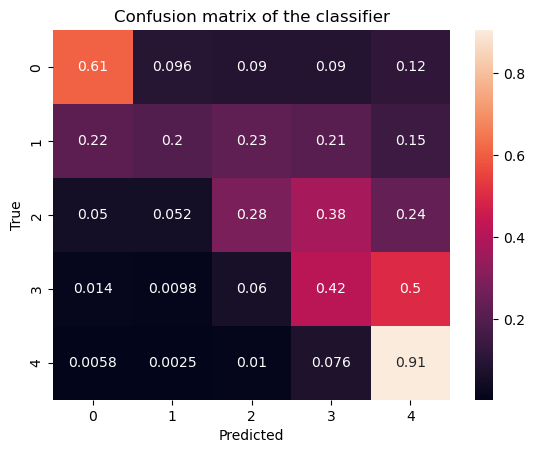

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate accuracy
def evaluate_classification(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4, 5], normalize='true')
    sns.heatmap(conf_matrix, annot=True)
    plt.title('Confusion matrix of the classifier')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate XGBoost
print("XGBoost Performance:")
evaluate_classification(y_val, xgb_preds)


In [34]:
# Load train and test data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Match the rows in train_data where the Id matches the ones in test_data
matched_train_data = train_data[train_data['Id'].isin(test_data['Id'])]

# Sort the train_data based on 'Id' to ensure it matches the order in test_data
test_data = matched_train_data.set_index('Id').loc[test_data['Id']].reset_index()

# Preview the matched data
test_data.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score
0,1323432,B0034G4P30,A120UTHQDQIJGH,0,0,1391040000,Okay for a rental,This movie was just alright for me. I think pe...,NaN
1,1137299,B0012IWO0I,A3SJBFCTJWBFT2,1,1,1388188800,Great for kids,My kids love this movie. Exciting and fun to ...,NaN
2,1459366,B005FUTBSC,A1V6FRU7EXP6N9,0,0,1356739200,good movie,"The effects were good, not the best but far fr...",NaN
3,931601,B000AREXBU,ARXDDR76Z5Q2I,5,5,1169510400,Excellent quality dvd. Don't pay big bucks fo...,"I just got a copy of this S. Korean dvd of ""He...",NaN
4,1311995,B002ZG99B8,A2XAS9GVZL3B1,2,2,1392595200,A mixed review,"OK, to put this clearly and bluntly... if you ...",NaN


In [35]:
# Fill missing values for the 'HelpfulnessRatio' and 'Year' columns in test_data
test_data['HelpfulnessNumerator'] = test_data['HelpfulnessNumerator'].fillna(0)
test_data['HelpfulnessDenominator'] = test_data['HelpfulnessDenominator'].fillna(1)  # Avoid division by zero
test_data['HelpfulnessRatio'] = test_data['HelpfulnessNumerator'] / test_data['HelpfulnessDenominator']

# Fill missing values in the 'Year' column in test_data
test_data['Year'] = pd.to_datetime(test_data['Time'], unit='s', errors='coerce').dt.year
test_data['Year'] = test_data['Year'].fillna(test_data['Year'].median())  # Fill missing year values

# Fill missing text data with an empty string in test_data
test_data['Text'] = test_data['Text'].fillna('')
test_data['Summary'] = test_data['Summary'].fillna('')

# Apply the same TF-IDF vectorizer for text data in test_data (use the same vectorizer that was fit on train_data)
X_test_text = tfidf.transform(test_data['Text'])

# Apply sentiment analysis on Text and Summary columns in test_data
test_data['text_sentiment'] = test_data['Text'].apply(lambda x: sia.polarity_scores(x)['compound'])
test_data['summary_sentiment'] = test_data['Summary'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Get the current year
current_year = datetime.datetime.now().year

# Convert the 'Time' column into a datetime format and extract the year in test_data
test_data['review_year'] = pd.to_datetime(test_data['Time'], unit='s').dt.year

# Calculate the age of the review in test_data
test_data['review_age'] = current_year - test_data['review_year']

# Merge the user-level features into the test_data based on user behavior calculated from train_data
test_data = test_data.merge(user_agg, on='UserId', how='left')

# Fill missing values for user-level features in test_data
test_data[['avg_user_rating', 'total_user_reviews', 'total_helpfulness_votes']] = test_data[['avg_user_rating', 'total_user_reviews', 'total_helpfulness_votes']].fillna(0)

# Define numeric features to be added for test_data
numeric_features_test = test_data[['text_sentiment', 'summary_sentiment', 'review_age', 'avg_user_rating', 'total_user_reviews', 'total_helpfulness_votes']].fillna(0)

# Convert numeric features to a sparse matrix for test_data
X_test_numeric = np.array(numeric_features_test)

# Combine text and numeric features for test_data (use X_test_text from TF-IDF and X_test_numeric from numeric features)
X_test_combined = hstack([X_test_text, X_test_numeric])


In [36]:
# Make predictions on the test data using the trained model (e.g., xgb_model)
test_preds_adjusted = xgb_model.predict(X_test_combined)
# Convert predictions back to 1-based star ratings
test_preds = test_preds_adjusted + 1  # Convert from 0-4 to 1-5

In [37]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_data['Id'],
    'Score': test_preds
})

submission.to_csv('data/submission.csv', index=False)